In [1]:
import os
import os.path as osp
import pprint
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt
import scipy.io as sio

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.models.HT import hough_transform

from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to
import cv2
from IPython.display import Image, display

In [2]:
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [3]:
def c(x):
    return sm.to_rgba(x)

In [4]:
config_file = "config/wireframe.yaml"
C.update(C.from_yaml(filename=config_file))
M.update(C.model)
pprint.pprint(C, indent=4)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

{   'io': {   'datadir': 'data/wireframe/',
              'logdir': 'logs/',
              'num_workers': 4,
              'outdir': 'results/',
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_interval': 20000,
              'vote_index': 'vote_index_128_128_3_1.mat'},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 5,
                 'batch_size_eval': 2,
                 'depth': 4,
                 'dim_fc': 1024,
                 'dim_loi': 128,
                 'eval_junc_thres': 0.008,
                 'head_size': <BoxList: [[2], [1], [2]]>,
                 'image': {   'mean': <BoxList: [109.73, 103.832, 98.681]>,
                              'stddev': <BoxList: [22.275, 22.124, 23.229]>},
                 'loss_weight': {   'jmap': 8.0,
                                    'joff': 0.25,
                                    'lmap': 0.5,
                                    'lneg': 1,
            

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device_name = "cpu"
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(0)
print("Let's use", torch.cuda.device_count(), "GPU(s)!")

Let's use 0 GPU(s)!


In [6]:
device = torch.device(device_name)
checkpoint = torch.load("pretrained_models/ht_lcnn/checkpoint.pth.tar", map_location=device)


In [7]:
# Load model
if os.path.isfile(C.io.vote_index):
    vote_index = sio.loadmat(C.io.vote_index)['vote_index']
else:
    vote_index = hough_transform(rows=128, cols=128, theta_res=3, rho_res=1)
    sio.savemat(C.io.vote_index, {'vote_index': vote_index})
vote_index = torch.from_numpy(vote_index).float().contiguous().to(device)
print('load vote_index', vote_index.shape)

load vote_index torch.Size([128, 128, 182, 60])


In [8]:
model = lcnn.models.hg(
    depth=M.depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
    num_stacks=M.num_stacks,
    num_blocks=M.num_blocks,
    num_classes=sum(sum(M.head_size, [])),
    vote_index=vote_index,

)
model = MultitaskLearner(model)
model = LineVectorizer(model)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

LineVectorizer(
  (backbone): MultitaskLearner(
    (backbone): HourglassNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck2D(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (layer2): Sequential(
        (0): Bottleneck2D(
          (bn

In [9]:
img = "pictures/02_u.png"
print(f"Processing {img}")
im = skimage.io.imread(img)
# cv2.imshow("img",im)
# cv2.waitKey(0) 
# display(Image(im))

Processing pictures/02_u.png


In [10]:
if im.ndim == 2:
    im = np.repeat(im[:, :, None], 3, 2)
im = im[:, :, :3]
im_resized = skimage.transform.resize(im, (512, 512)) * 255
image = (im_resized - M.image.mean) / M.image.stddev
image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()

In [11]:
# cv2.imshow("img",image)
# cv2.waitKey(0) 

In [12]:
with torch.no_grad():
    input_dict = {
        "image": image.to(device),
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    H = model(input_dict)["preds"]

In [13]:
lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
scores = H["score"][0].cpu().numpy()
print('lines: ',lines, ', scores: ', scores)
for i in range(1, len(lines)):
    if (lines[i] == lines[0]).all():
        lines = lines[:i]
        scores = scores[:i]
        break

lines:  [[[ 159.9613452  1152.59567261]
  [ 102.40674019 1156.80328369]]

 [[ 121.03652716 1157.0539093 ]
  [ 159.9613452  1152.59567261]]

 [[ 142.09206104  772.27645874]
  [  94.76461172  767.3197937 ]]

 ...

 [[ 184.48684216  246.84267044]
  [ 273.64396334    2.54628956]]

 [[ 219.8366189  1065.65986633]
  [ 204.99001265 1026.24588013]]

 [[ 277.36611843  645.56747437]
  [ 278.42494726  895.39985657]]] , scores:  [0.99945277 0.9994261  0.9992849  ... 0.880131   0.87772757 0.87694514]


In [14]:

# postprocess lines to remove overlapped lines
diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

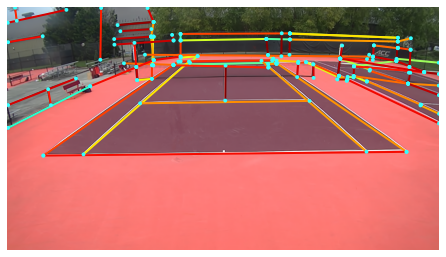

In [15]:
t = 0.94
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
    plt.scatter(a[1], a[0], **PLTOPTS)
    plt.scatter(b[1], b[0], **PLTOPTS)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()

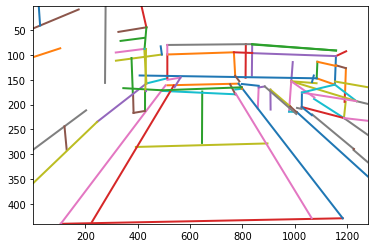

In [16]:
t = 0.94
plt.figure(1)
# plt.gca().set_axis_off()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
    # plt.scatter(a[1], a[0], **PLTOPTS)
    # plt.scatter(b[1], b[0], **PLTOPTS)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().invert_yaxis()
plt.show()
plt.close()